# Current speed vs obs

In [1]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

netcdf_index loaded.


/home/156/aek156/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

1993-2017
tstart =  1993-01-01 00:00:00
tend =  2018-01-01 00:00:00


In [3]:
# cc.start_cluster()

In [4]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
#     plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
# cc.build_index()

In [6]:
obs_file = xr.open_dataset('/g/data3/hh5/tmp/cosima/observations/original/drifter_annualmeans.nc').rename({'Lat':'latitude','Lon':'longitude'})
obs_u = obs_file['U']
obs_v = obs_file['V']
# obs_lat = obs_file['latitude']
# obs_lon = obs_file['longitude']
obs_speed = np.sqrt(obs_u**2+obs_v**2)
# obs_speed = np.swapaxes(obs_speed,0,1)
del(obs_u, obs_v)

In [7]:
# location coords: [ minlon, maxlon, minlat, maxlat ]
# key names are used as filenames so should not have spaces
locations = { 
#               'EAC_ACC_SouthPacific': [140-360,240-360,-65,-20], 
#               'EAC_ACC':             [140-360,190-360,-65,-20],
              'EAC':                     [145-360,175-360,-45,-20],
              'Kuroshio':                [125-360,155-360,25,50],
              'GulfStream':             [-85,-50,25,50],
              'Agulhas':                 [10,40,-45,-20]
    # TODO: ACC
}

In [8]:
use_cache = True

In [15]:
# load model speed climatologies and snapshots
speeds = copy.deepcopy(exptdata.exptdict)  # this will store speed fields under the same keys as exptdata.exptdict
for ekey in speeds.keys():
        expt = speeds[ekey]['expt']
#         n_files = speeds[ekey]['n_files']
        n_files = None
        time_units = speeds[ekey]['time_units']
        offset = speeds[ekey]['offset']
#         print(ekey, n_files)

        ## Load zonal velocity from expt
        tmp = cc.get_nc_variable(expt, 'ocean.nc', 'u',n=n_files,time_units=time_units, offset=offset, use_cache=use_cache)
        u = tmp.isel(st_ocean=0).sel(time=slice(tstart,tend)).mean('time')
        u_snap = tmp.isel(st_ocean=0).isel(time=-1)

        ## Load meridional velocity from expt 
        tmp = cc.get_nc_variable(expt, 'ocean.nc', 'v',n=n_files,time_units=time_units, offset=offset, use_cache=use_cache)
        v = tmp.isel(st_ocean=0).sel(time=slice(tstart,tend)).mean('time')
        v_snap = tmp.isel(st_ocean=0).isel(time=-1)
        
        print(tmp['time'].data[-1])
        speeds[ekey]['tsnap'] = tmp['time'].data[-1]
        
        speeds[ekey]['speed'] = np.sqrt(u**2+v**2)
        speeds[ekey]['speed_snap'] = np.sqrt(u_snap**2+v_snap**2) 
        
        del(tmp, u, v)

Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean.nc_u_None_days-since-1718-01-01_-87658_False.pkl
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean.nc_v_None_days-since-1718-01-01_-87658_False.pkl
2017-06-30T12:00:00.000000000
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi_ocean.nc_u_None_days-since-1718-01-01_-87658_False.pkl
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi_ocean.nc_v_None_days-since-1718-01-01_-87658_False.pkl
2017-06-30T12:00:00.000000000
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_u_None_None_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_v_None_None_None_False.pkl
2017-12-14T12:00:00.000000000


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


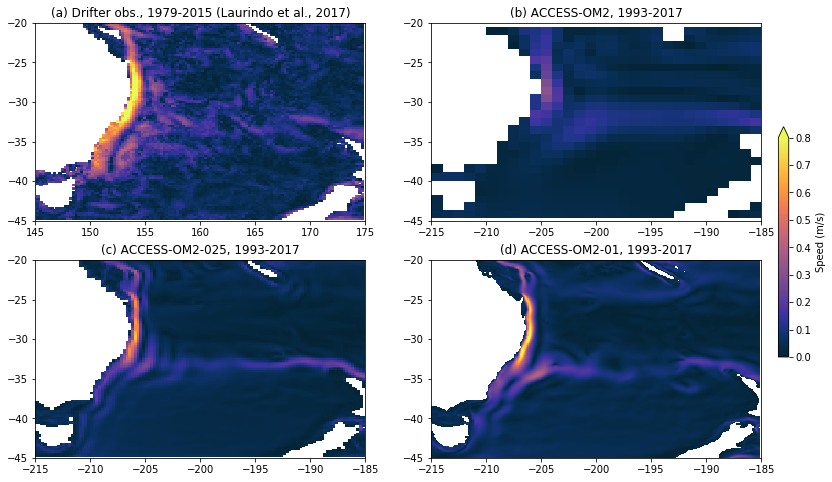

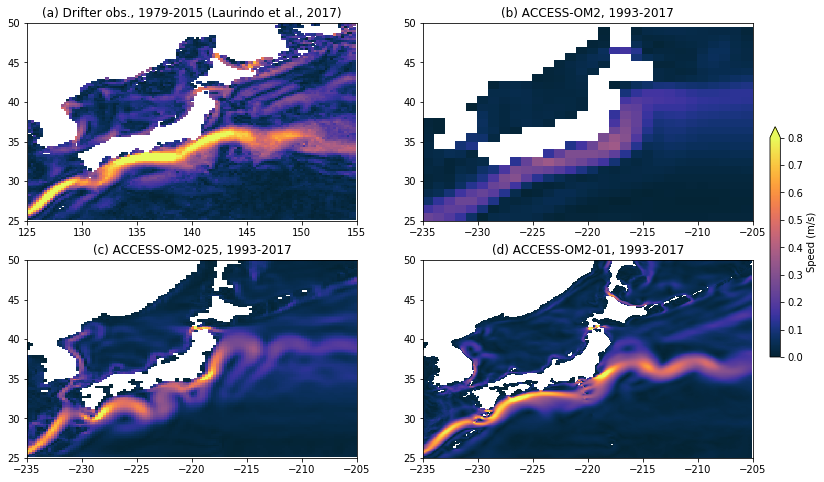

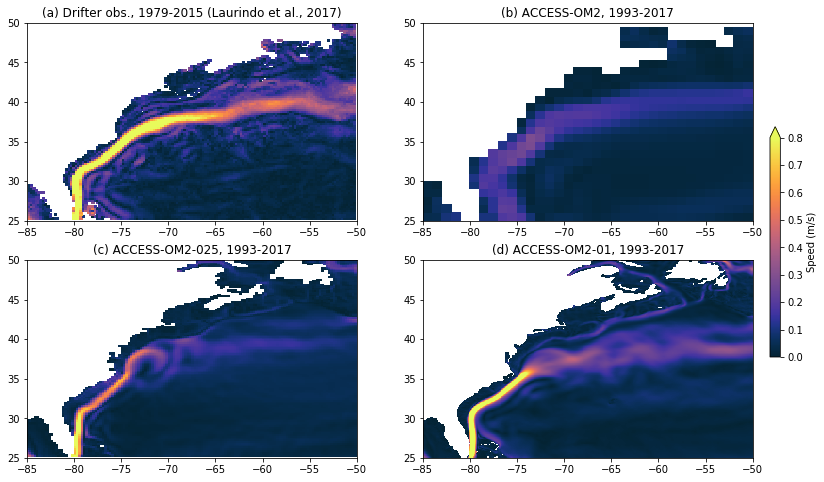

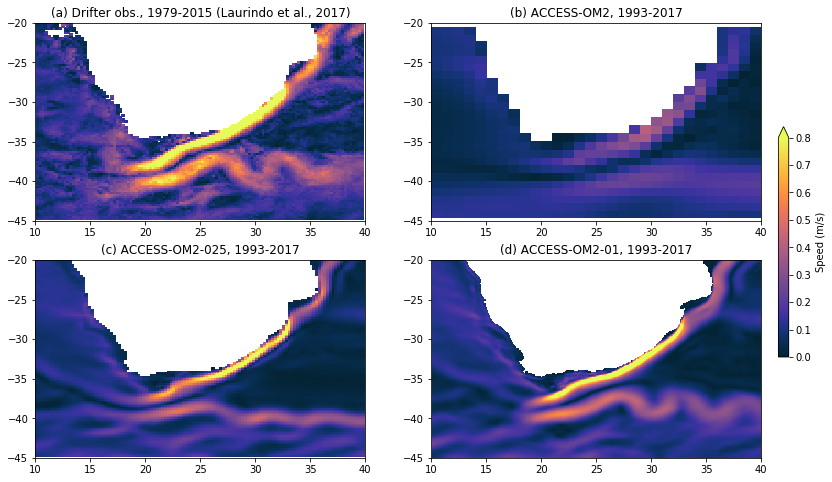

In [16]:
# plot obs and all model mean speeds in each location
vmax = 0.8
ncols = 2
nrows = math.ceil((len(speeds)+1)/ncols)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(12,8))
    #fig.suptitle('Observed surface current climatology and '+str(clim_years)+'-year model mean', fontsize=14)
    oloc = copy.copy(loc)
    # BUG: this probably won't work for regions that straddle 180E
    if oloc[0]<-180:
        oloc[0] = oloc[0]+360
    if oloc[1]<-180:
        oloc[1] = oloc[1]+360
    obs_speed_loc = obs_speed.sel(latitude=slice(oloc[2],oloc[3])).sel(longitude=slice(oloc[0],oloc[1]))
    ax = fig.add_subplot(ncols, nrows, 1)
    cax = ax.pcolormesh(obs_speed_loc.longitude, obs_speed_loc.latitude, np.swapaxes(obs_speed_loc,0,1), 
                        shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
    plt.title('(a) Drifter obs., 1979-2015 (Laurindo et al., 2017)')
    plt.xlim(oloc[0],oloc[1])
    plt.ylim(oloc[2],oloc[3])

    for i, ekey in enumerate(speeds.keys()):
        ax = fig.add_subplot(ncols, nrows, i+2)
        speed = speeds[ekey]['speed'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
        cax = ax.pcolormesh(speed.xu_ocean, speed.yu_ocean, speed, 
                            shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
        plt.title(speeds[ekey]['desc'], fontsize=12)
        plt.xlim(loc[0],loc[1])
        plt.ylim(loc[2],loc[3])
        
    plt.subplot(222)
    plt.title('(b) ACCESS-OM2, '+yearrange)
    plt.subplot(223)
    plt.title('(c) ACCESS-OM2-025, '+yearrange)
    plt.subplot(224)
    plt.title('(d) ACCESS-OM2-01, '+yearrange)
    
    plt.subplots_adjust(left=0.08,right=0.92)
    ax1 = plt.axes([0.94,0.3,0.012,0.4])
    cb = plt.colorbar(cax,cax=ax1,orientation='vertical',extend='max')
    cb.ax.set_ylabel('Speed (m/s)')
    savefigure(locname+'_clim')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


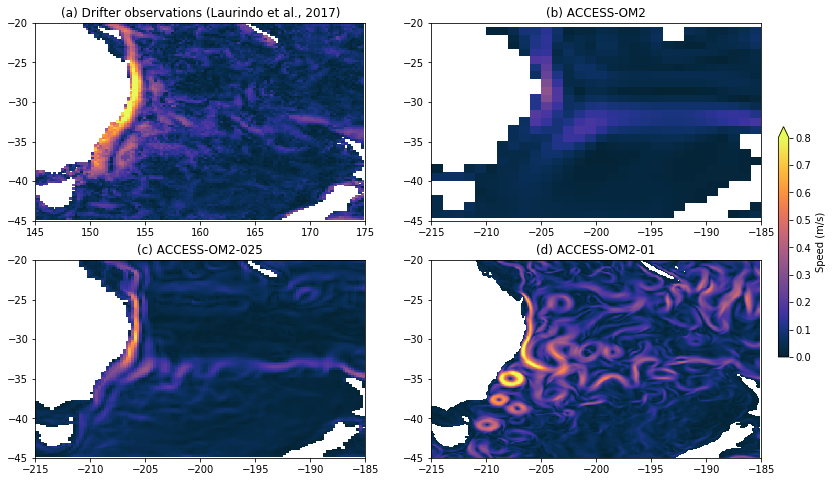

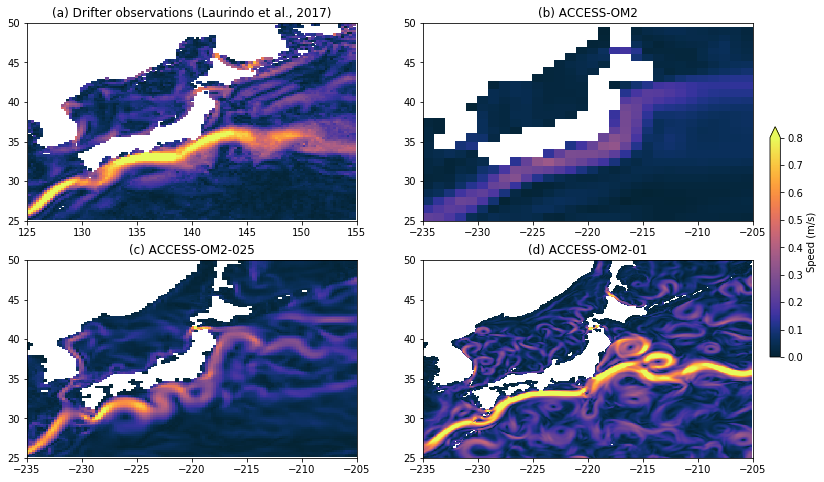

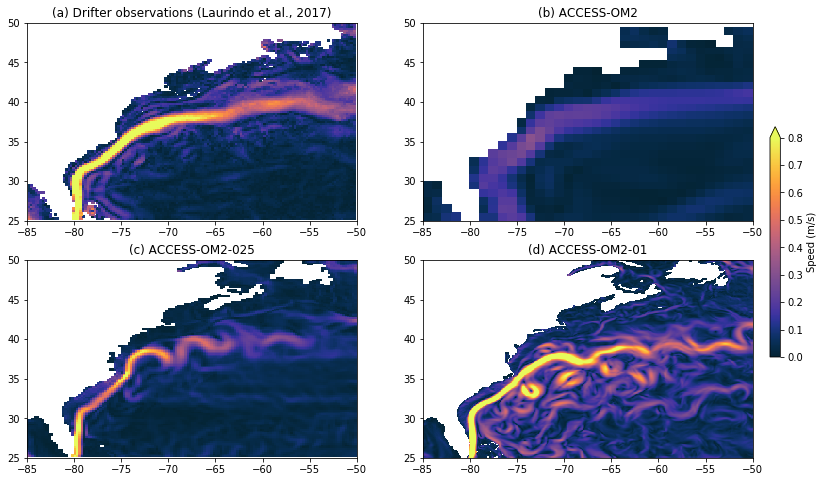

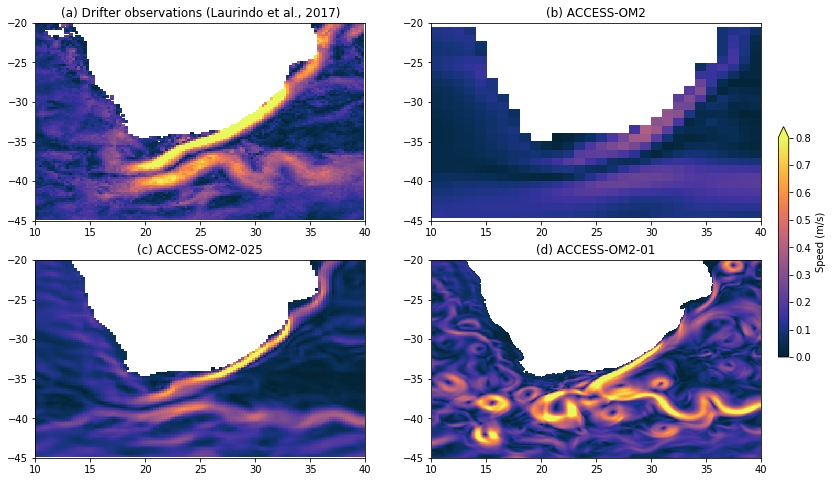

In [10]:
# plot obs and all model "snapshot" speeds in each location

# NB "snapshot" is actually annual mean for 1, 0.25deg and monthly mean for 0.1deg
#   ...but could use daily surface vel from ice output at 0.1 deg if we wanted
# TODO: save daily surface vel at all resolutions
# TODO: also open final .nc file as dataset and use ds.time_bounds.astype('int64') 
#   to make title string specifying averaging date range - see ice_validation
#   ideally do this via cookbook changes: https://github.com/OceansAus/cosima-cookbook/issues/111


vmax = 0.8
ncols = 2
nrows = math.ceil((len(speeds)+1)/ncols)
for locname,loc in locations.items():
    fig = plt.figure(figsize=(12,8))
    #fig.suptitle('Observed surface current climatology and model snapshots - TODO: get 1-day snapshots from ice', fontsize=14)
    oloc = copy.copy(loc)
    # BUG: this probably won't work for regions that straddle 180E
    if oloc[0]<-180:
        oloc[0] = oloc[0]+360
    if oloc[1]<-180:
        oloc[1] = oloc[1]+360
    obs_speed_loc = obs_speed.sel(latitude=slice(oloc[2],oloc[3])).sel(longitude=slice(oloc[0],oloc[1]))
    ax = fig.add_subplot(ncols, nrows, 1)
    cax = ax.pcolormesh(obs_speed_loc.longitude, obs_speed_loc.latitude, np.swapaxes(obs_speed_loc,0,1), 
                        shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
    plt.title('(a) Drifter observations (Laurindo et al., 2017)', fontsize=12)
    plt.xlim(oloc[0],oloc[1])
    plt.ylim(oloc[2],oloc[3])
    #fig.colorbar(cax,shrink=0.8,label='Speed (m/s)',extend='max')

    for i, ekey in enumerate(speeds.keys()):
        ax = fig.add_subplot(ncols, nrows, i+2)
        speed = speeds[ekey]['speed_snap'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
        cax = ax.pcolormesh(speed.xu_ocean, speed.yu_ocean, speed, 
                            shading='flat', cmap=cm.cm.thermal, vmin=0, vmax=vmax)
        plt.title(speeds[ekey]['desc'], fontsize=12)
        plt.xlim(loc[0],loc[1])
        plt.ylim(loc[2],loc[3])
        
    plt.subplot(222)
    plt.title('(b) ACCESS-OM2, ' + speeds[ekey]['tsnap'])
    plt.subplot(223)
    plt.title('(c) ACCESS-OM2-025, ' + speeds[ekey]['tsnap'])
    plt.subplot(224)
    plt.title('(d) ACCESS-OM2-01, ' + speeds[ekey]['tsnap'])
    
    plt.subplots_adjust(left=0.08,right=0.92)
    ax1 = plt.axes([0.94,0.3,0.012,0.4])
    cb = plt.colorbar(cax,cax=ax1,orientation='vertical',extend='max')
    cb.ax.set_ylabel('Speed (m/s)')
    
    savefigure(locname+'_snap')